In [1]:
# For data manipulation
import numpy as np
import pandas as pd
import yfinance as yf
import pyfolio as pf
from hmmlearn import hmm
from sklearn.utils import check_random_state

# For data visualization
import matplotlib.pyplot as plt

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

/home/josgt/anaconda3/envs/tradingapp/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/home/josgt/anaconda3/envs/tradingapp/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# Function to create the DC indicators provided by Chen and Tsang (2021)
def directional_change_events(data, theta=0.2):

    # Copy the dataframe
    data = data.copy()

    # Create the necessary columns and variables
    data["Event"] = 0.0

    # Set the initial event variable value
    event = "upward" # initial event

    # Set the initial value for low and high prices
    ph = data['Close'].iloc[0] # highest price
    pl = data['Close'].iloc[0] # lowest price

    # Create loop to run through each date
    for t in range(0, len(data.index)):
        # Check if we're on a downward trend
        if event == "downward":
            # Check if the close price is higher than the low price by the theta threshold
            if data["Close"].iloc[t] >= pl * (1 + theta):
                # Set the event variable to upward
                event = "upward"
                # Set the high price as the current close price                
                ph = data["Close"].iloc[t]
            # If the close price is lower than the low price by the theta threshold
            else:
                # Check if the close price is less than the low price
                if data["Close"].iloc[t] < pl:
                    # Set the low price as the current close price
                    pl = data["Close"].iloc[t]
                    # Set the Event to upward for the current period
                    data["Event"].iloc[t] = 1
        # Check if we're on a upward trend
        elif event == "upward":
            # Check if the close price is less than the high price by the theta threshold
            if data["Close"].iloc[t] <= ph * (1 - theta):  
                # Set the event variable to downward
                event = "downward"
                # Set the low price as the current close price
                pl = data["Close"].iloc[t]
            # If the close price is higher than the high price by the theta threshold
            else:
                # Check if the close price is higher than the high price
                if data["Close"].iloc[t] > ph:
                    # Set the high price as the current close price
                    ph = data["Close"].iloc[t]
                    # Set the Event to downward for the current period
                    data["Event"].iloc[t] = -1

    # Set the peak and trough prices and forward-fill the column
    data['peak_trough_prices'] = np.where(data['Event']!=0, data['Close'],0)
    data['peak_trough_prices'].replace(to_replace=0, method='ffill', inplace=True)

    # Count the number of periods between a peak and a trough
    data['count'] = 0
    for i in range(1,len(data.index)):
        if data['Event'].iloc[(i-1)]!=0:
            data['count'].iloc[i] = 1+data['count'].iloc[(i-1)]
        else:
            data['count'].iloc[i] = 1

    # Compute the TMV indicator
    data['TMV'] = np.where(data['Event']!=0, abs(data['peak_trough_prices']-data['peak_trough_prices'].shift())/\
                          (data['peak_trough_prices'].shift()*theta),0)

    # Compute the time-completion-for-a-trend indicator
    data['T'] = np.where(data['Event']!=0, data['count'],0)

    # Compute the time-adjusted-return indicator and forward-fill it
    data['R'] = np.where(data['Event']!=0, np.log(data['TMV']/data['T']*theta),0)
    data['R'] = data['R'].replace(to_replace=0, method='ffill')

    # Drop NaN or inifinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    return data

In [3]:
# Download the GBPUSD data from 2003 to 2013
data = yf.download('GBPUSD=X', start='2003-12-01', end='2023-10-06', auto_adjust=True)

# Compute the log returns
data['returns'] = np.log(data['Close']/data['Close'].shift(1))

# Print the data
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,returns
Date,,,,,,
2003-12-01,1.723811,1.727205,1.718390,1.718597,0,NaN
2003-12-02,1.719010,1.732112,1.717298,1.730313,0,0.006794
2003-12-03,1.730493,1.731812,1.725209,1.728101,0,-0.001280
2003-12-04,1.727414,1.728997,1.718302,1.720697,0,-0.004294
2003-12-05,1.720608,1.733102,1.719809,1.733102,0,0.007184
...,...,...,...,...,...,...
2023-09-29,1.220852,1.227144,1.218249,1.220480,0,0.005708
2023-10-02,1.219111,1.221956,1.211637,1.219304,0,-0.000964
2023-10-03,1.208883,1.210097,1.205458,1.209117,0,-0.008390


In [4]:
# Compute the DC indicators
data = directional_change_events(data, theta=0.004)

# Change the index type to datetime
data.index = pd.to_datetime(data.index)

# Drop NaN values
data.dropna(inplace=True)

# Present the data
data

,Open,High,Low,Close,Volume,returns,Event,peak_trough_prices,count,TMV,T,R
Date,,,,,,,,,,,,
2003-12-08,1.729505,1.736202,1.727504,1.734214,0,0.000641,-1.0,1.734214,1,0.563610,1,-6.094854
2003-12-09,1.733703,1.747793,1.733613,1.745414,0,0.006437,-1.0,1.745414,2,1.614523,2,-5.735569
2003-12-10,1.745292,1.748007,1.735900,1.739796,0,-0.003224,0.0,1.745414,3,0.000000,0,-5.735569
2003-12-11,1.740008,1.747702,1.737891,1.746206,0,0.003678,-1.0,1.746206,1,0.113495,1,-7.697456
2003-12-12,1.746298,1.751099,1.744287,1.747305,0,0.000629,-1.0,1.747305,2,0.157271,2,-8.064390
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29,1.220852,1.227144,1.218249,1.220480,0,0.005708,0.0,1.213533,7,0.000000,0,-8.754433
2023-10-02,1.219111,1.221956,1.211637,1.219304,0,-0.000964,0.0,1.213533,1,0.000000,0,-8.754433
2023-10-03,1.208883,1.210097,1.205458,1.209117,0,-0.008390,0.0,1.213533,1,0.000000,0,-8.754433


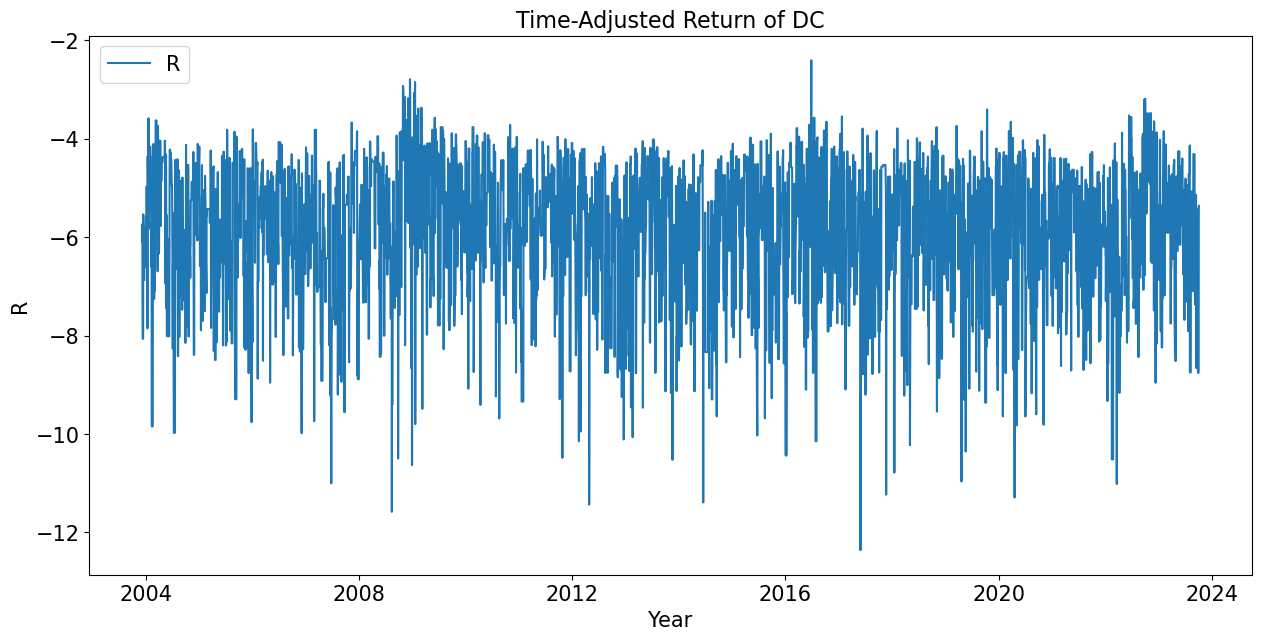

In [5]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot the R indicator
plt.plot(data.index, data['R'], label = "R")

# Set the title of the graph
plt.title('Time-Adjusted Return of DC', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('R', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.savefig('Figures/R_time_series.png', bbox_inches='tight')
plt.show()

In [6]:
# Count number of downward and upward events
data['Event'].value_counts()

 0.0    2824
 1.0    1167
-1.0    1165
Name: Event, dtype: int64

In [7]:
# Create an HMM object with two hidden states
model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 100, random_state = 42)

# Create an array input for the HMM model
X = data[['R']].values

# Estimate the HMM model
results = model.fit(X)

# Use the Viterbi algorithm to find the fitted hidden states
data['states'] = results.predict(X)

# Count the number of days in which we find the two states
data['states'].value_counts()

1    3223
0    1933
Name: states, dtype: int64

In [8]:
# Find the R mean for state 0
state0_R_vol = data['R'][data['states']==0].mean()

# Find the R mean for state 1
state1_R_vol = data['R'][data['states']==1].mean()

# Print the R volatility for both states
print(f'Volatility for state 0, 1 and 2 are {state0_R_vol:.2f} and {state1_R_vol:.2f}, respectively')

Volatility for state 0, 1 and 2 are -4.68 and -6.80, respectively


In [9]:
# Find the returns standard deviation for state 0
state0_vol = data['returns'][data['states']==0].std()*np.sqrt(252)*100

# Find the returns standard deviation for state 1
state1_vol = data['returns'][data['states']==1].std()*np.sqrt(252)*100

# Print the returns volatility for both states
print(f'Volatility for state 0 and 1 are {state0_vol:.2f} and {state1_vol:.2f}, respectively')

Volatility for state 0 and 1 are 11.56 and 8.10, respectively


In [10]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [11]:
# Set the initial day to start the trading backtesting loop
initial_t = data.index.get_loc(data[data.index.year==2018].index[0])

# Print the initial day
initial_t

3653

In [12]:
# Create a simple 4-day moving average
data['sma'] = data['Close'].rolling(3).mean()

# Create the strategy signal
data['signal'] = np.where(data['Close']>data['sma'],1.0,-1.0)

# Create the leverage column
data['dc_leverage'] = 0.0

# Create the next state column
data['dc_next_state'] = 0.0

In [13]:
# Create the backtesting loop
for t in range(initial_t, (len(data.index)-1)):
    # Create a data sample to be used for the trading computations
    data_sample = data[['R','returns']].iloc[:(t+1)]

    # Create an HMM model object
    dc_model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 200, random_state = 100)

    # Create the array input to be used for the HMM model
    dc_X = data_sample[['R']].values

    # Fit the model to the data
    dc_results = dc_model.fit(dc_X)
    
    # Obtain the fitted hidden states for the data sample
    data_sample['dc_states'] = dc_results.predict(dc_X)

    # Compute the next state hidden state
    dc_transmat_cdf = np.cumsum(dc_results.transmat_, axis=1)
    dc_random_state = check_random_state(dc_results.random_state)
    data['dc_next_state'].iloc[t] = (dc_transmat_cdf[data_sample['dc_states'].iloc[-1]] > dc_random_state.rand()).argmax()
    
    # Compute the R volatility for each state
    dc_state0_vol = data_sample['R'][data_sample['dc_states']==0].mean()
    dc_state1_vol = data_sample['R'][data_sample['dc_states']==1].mean()

    # Invest all capital if the forecasted regime is 0 and its volatility is higher than regime 1
    if (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol>dc_state1_vol):
        data['dc_leverage'].iloc[t] = 1.0
    # Invest 2 times the capital if the forecasted regime is 0 and its volatility is lower than regime 1
    elif (data['dc_next_state'].iloc[t]==0) and (dc_state0_vol<dc_state1_vol):
        data['dc_leverage'].iloc[t] = 2.0
    # Invest 2 times the capital if the forecasted regime is 1 and its volatility is lower than regime 1
    elif (data['dc_next_state'].iloc[t]==1) and (dc_state0_vol>dc_state1_vol):
        data['dc_leverage'].iloc[t] = 2.0
    # Invest all capital if the forecasted regime is 1 and its volatility is higher than regime 1
    else:
        data['dc_leverage'].iloc[t] = 1.0

# Set the final signal to 0 to square off any open position
data['signal'].iloc[-1] = 0.0

In [14]:
# Subset the data for plotting
plot_data = data.loc['2018':]

# Count the number of days in which we face different leverages
plot_data['dc_leverage'].value_counts()

2.0    1003
1.0     499
0.0       1
Name: dc_leverage, dtype: int64

In [15]:
# Compute the Buy-and-Hold cumulative returns
plot_data['buy_hold_cum_rets'] = np.exp(plot_data['returns'].cumsum())

# Compute the simple 4-day moving average strategy returns
plot_data['basic_stra_rets'] = plot_data['returns']*plot_data['signal'].shift(1)

# Compute the simple 4-day moving average strategy cumulative returns
plot_data['basic_stra_cum_rets'] = np.exp(plot_data['basic_stra_rets'].cumsum())

# Compute the HMM-DC-based strategy returns
plot_data['hmm_dc_stra_rets'] = plot_data['returns']*plot_data['signal'].shift(1)*plot_data['dc_leverage'].shift(1)

# Compute the HMM-DC-based strategy cumulative returns
plot_data['hmm_dc_stra_cum_rets'] = np.exp(plot_data['hmm_dc_stra_rets'].cumsum())

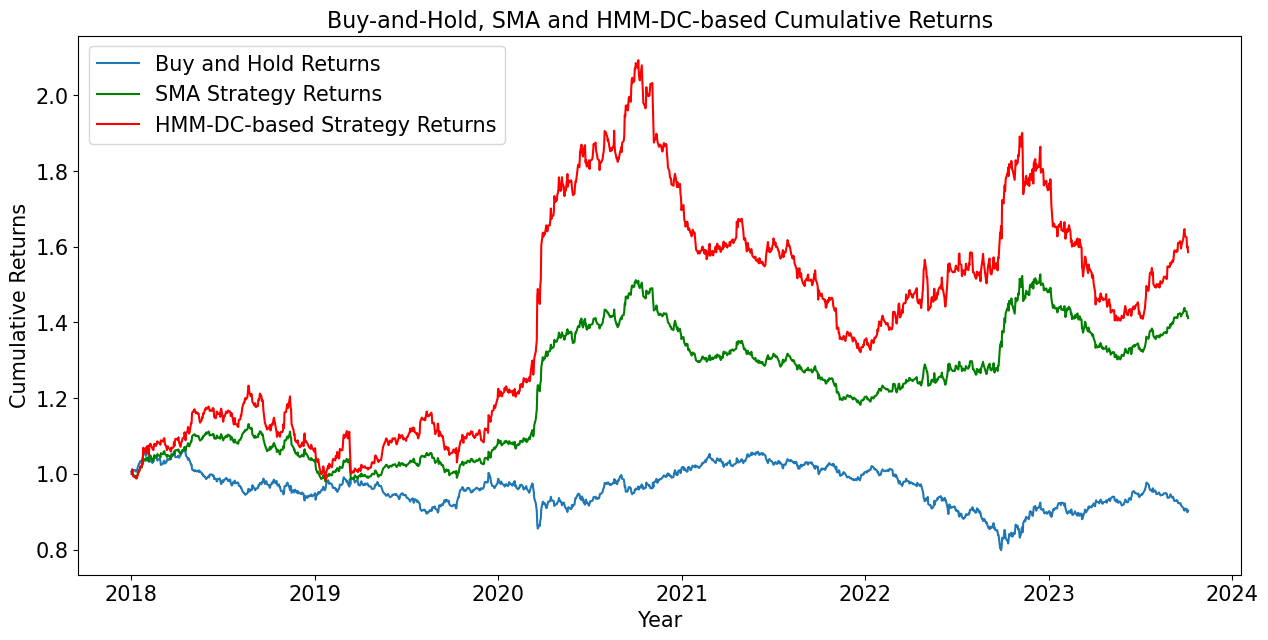

In [16]:
# Set the figure size
plt.figure(figsize=(15,7))

# Plot both the Buy-and-hold, SMA and HMM-DC-based strategy cumulative returns
plt.plot(plot_data.index, plot_data['buy_hold_cum_rets'], label = "Buy and Hold Returns")
plt.plot(plot_data.index, plot_data['basic_stra_cum_rets'], label = "SMA Strategy Returns", color='g')
plt.plot(plot_data.index, plot_data['hmm_dc_stra_cum_rets'], label = "HMM-DC-based Strategy Returns", color='r')

# Set the title of the graph
plt.title('Buy-and-Hold, SMA and HMM-DC-based Cumulative Returns', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year', fontsize=15)
plt.ylabel('Cumulative Returns', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.savefig('Figures/strategies_cum_returns.png', bbox_inches='tight')
plt.show()

Start date,2018-01-02
End date,2023-10-05
Total months,71
,Backtest
Annual return,-1.789%
Cumulative returns,-10.2%
Annual volatility,9.311%
Sharpe ratio,-0.15
Calmar ratio,-0.07
Stability,0.14
Max drawdown,-25.202%


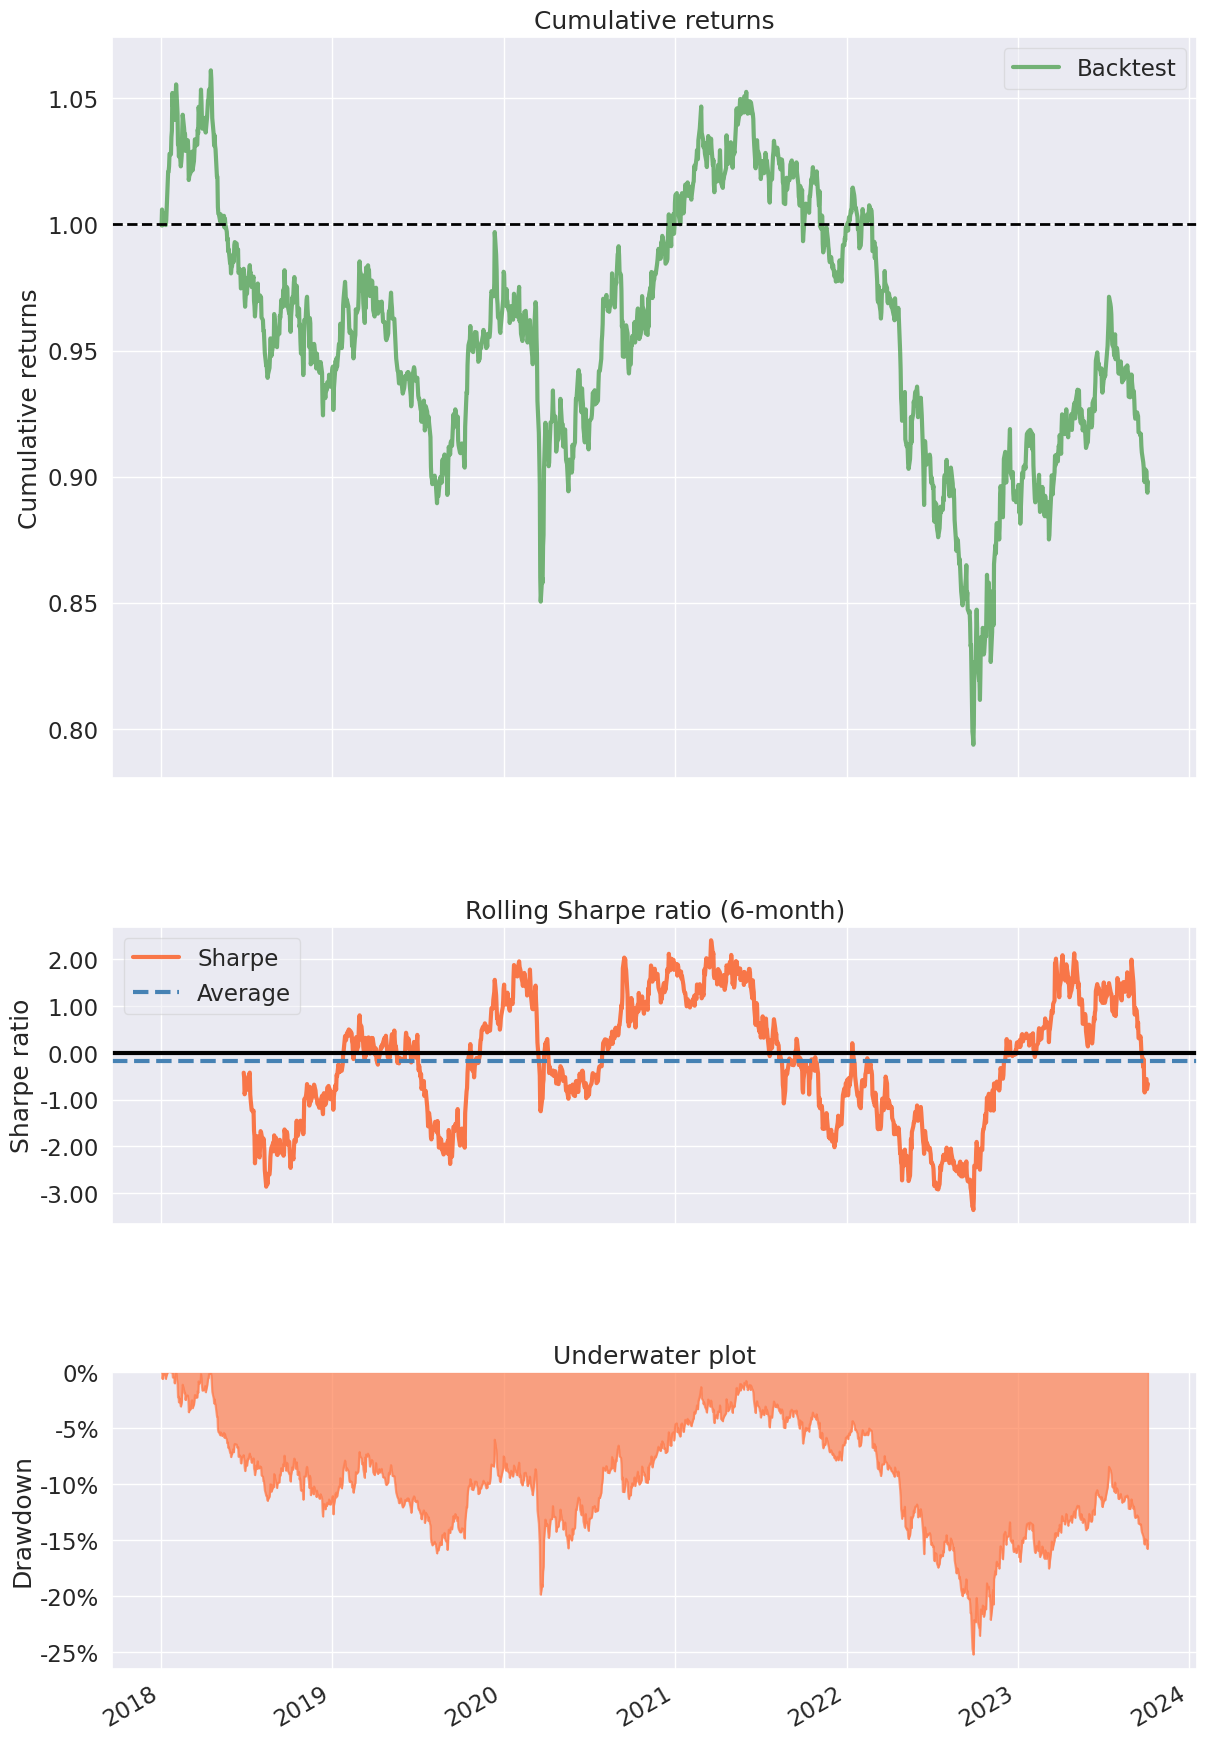

In [17]:
pf.create_simple_tear_sheet(plot_data['buy_hold_cum_rets'].pct_change().dropna())

Start date,2018-01-03
End date,2023-10-05
Total months,71
,Backtest
Annual return,5.963%
Cumulative returns,41.197%
Annual volatility,9.332%
Sharpe ratio,0.67
Calmar ratio,0.27
Stability,0.58
Max drawdown,-21.815%


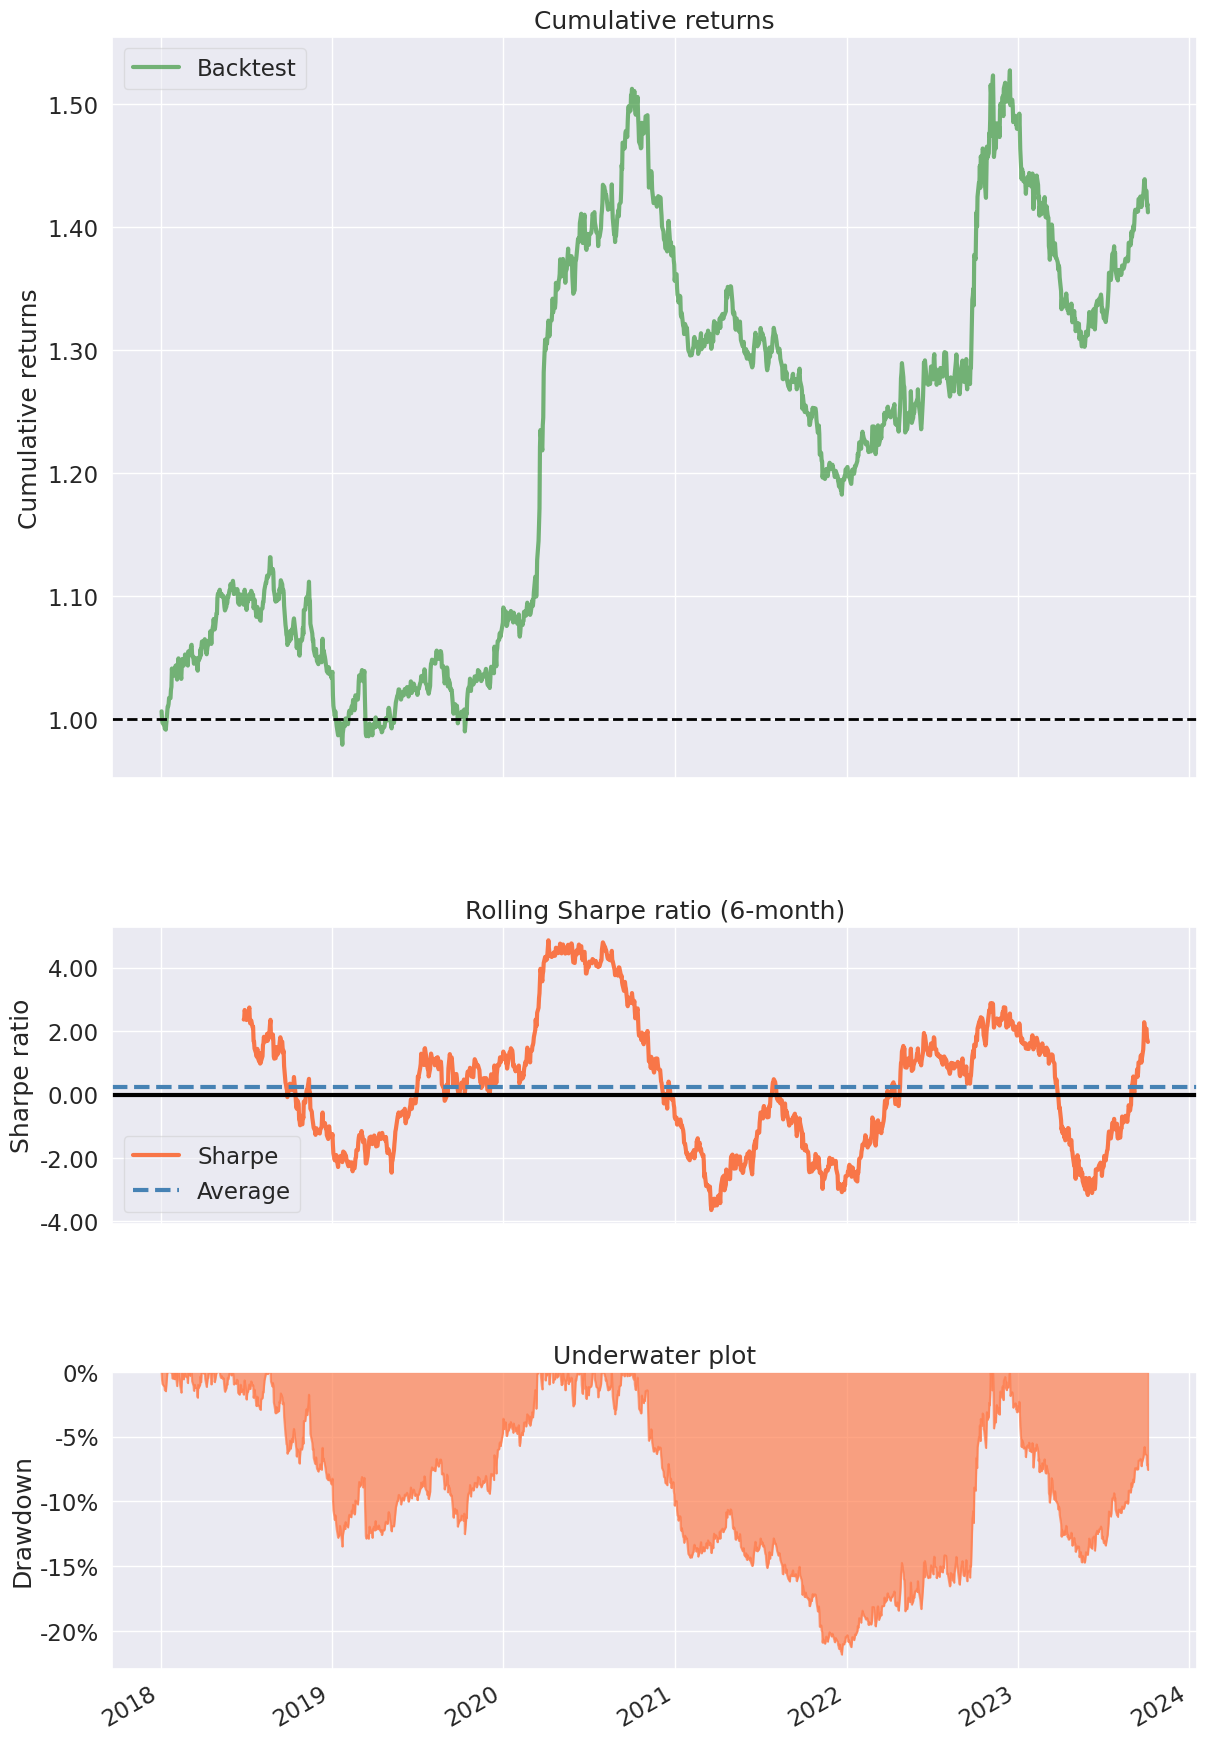

In [18]:
pf.create_simple_tear_sheet(plot_data['basic_stra_cum_rets'].pct_change().dropna())

Start date,2018-01-03
End date,2023-10-05
Total months,71
,Backtest
Annual return,8.059%
Cumulative returns,58.67%
Annual volatility,15.896%
Sharpe ratio,0.57
Calmar ratio,0.22
Stability,0.45
Max drawdown,-36.867%


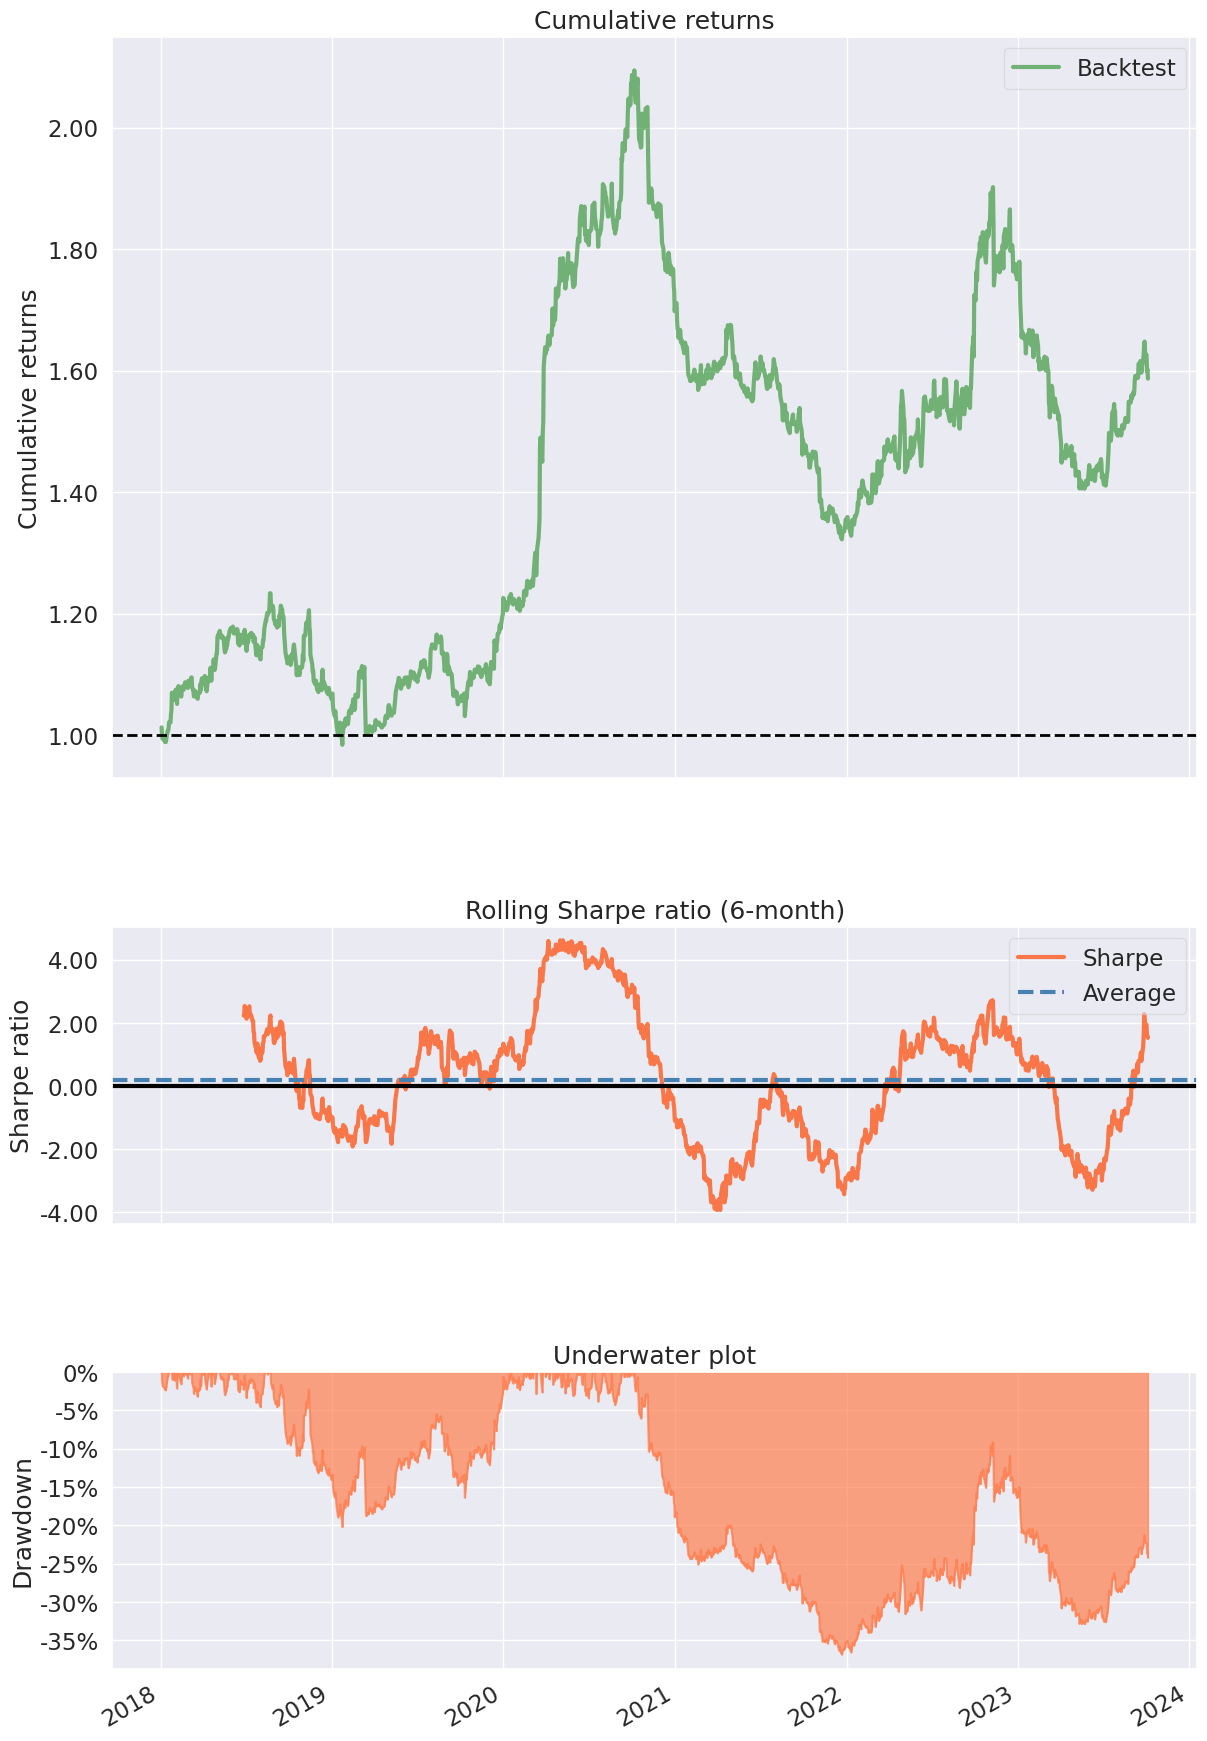

In [19]:
pf.create_simple_tear_sheet(plot_data['hmm_dc_stra_cum_rets'].pct_change().dropna())